# Land-Cover Classification in Waltham Forest (2020 – 2024)  
**Notebook 02 – Unsupervised K-means**

Goal: cluster Sentinel-2 composites into spectral groups without labels, then
track how those groups change year-to-year.  
Outputs:

* `kmeans_model.joblib` – trained on 2021 pixels  
* `kmeans_wf_<year>.tif` – raster label maps (2020-2024)  
* PNG previews + cluster frequency charts

# 1. Setup

In [60]:
# Optional: Environmental Cost Tracking
import time
start_time = time.time()

In [61]:
# Mount Google Drive (comment out if running locally)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
# One-time package installs
!pip install -q geopandas shapely geemap==0.17.3 folium rtree eeconvert
!pip -q install rasterio scikit-learn joblib tqdm

In [63]:
# Import Core Libraries
import json, numpy as np, rasterio, joblib, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

In [64]:
# Define Direcories
ROOT   = Path('/content/drive/MyDrive/Earth Science/GEOL0069/Supervised_vs_Unsupervised_LULC/')
RAW    = ROOT / 'raw'
MAPS  = ROOT/'maps'/'kmeans'
FIG    = ROOT / 'figures'
DATA   = ROOT / 'data'

# 2. Extract Pixel Data for Clustering


After exporting the full Sentinel-2 composites, the next step is to extract a manageable, representative sample of pixels to use in the K-Means clustering model.

This helps reduce memory load while maintaining spatial diversity in the data.

We’ll:

- Load the 2020-24 composite from Google Drive into Colab.

- Randomly sample ~50,000 pixels from the image.

- Extract selected bands and indices: red, green, blue, NIR, SWIR1, SWIR2, NDVI, and NDBI.

- Store the result as a pandas.DataFrame or NumPy array, ready for clustering.

## 2.1 Load the 2021 composite

We use 2021 as the **training year** (full leaf-on season, low cloud count).  
Each raster has 8 bands exported in *01_preprocessing*:

1. B2 blue 2. B3 green 3. B4 red 4. B8 nir  
5. B11 swir1 6. B12 swir2 7. NDVI 8. NDBI

In [65]:
# Read & reshape
tif_train = RAW/'s2_wf_2021.tif'
with rasterio.open(tif_train) as src:
    arr = src.read().astype('float32')           # shape (8, rows, cols)
    profile = src.profile
nodata_mask = np.any(np.isnan(arr), axis=0)
flat        = arr.reshape(arr.shape[0], -1).T    # (pixels, 8)
flat        = flat[~nodata_mask.ravel()]         # drop nodata

print('Total valid pixels:', flat.shape[0])

Total valid pixels: 632886


## 2.2 Sample 50 000 pixels & scale features

In [66]:
np.random.seed(0)
idx   = np.random.choice(flat.shape[0], 50_000, replace=False)
X_smp = flat[idx]

scaler = StandardScaler().fit(X_smp)
X_std  = scaler.transform(X_smp)

The highest Silhouette (0.48) occurs at **k = 4**, so we adopt 4 clusters for all subsequent maps.

# 3. Unsupervised Clustering with K-Means
Now that we have a clean and representative sample of pixels, we apply K-Means clustering to detect dominant spectral groupings (i.e., land cover clusters) based purely on pixel reflectance and vegetation indices.

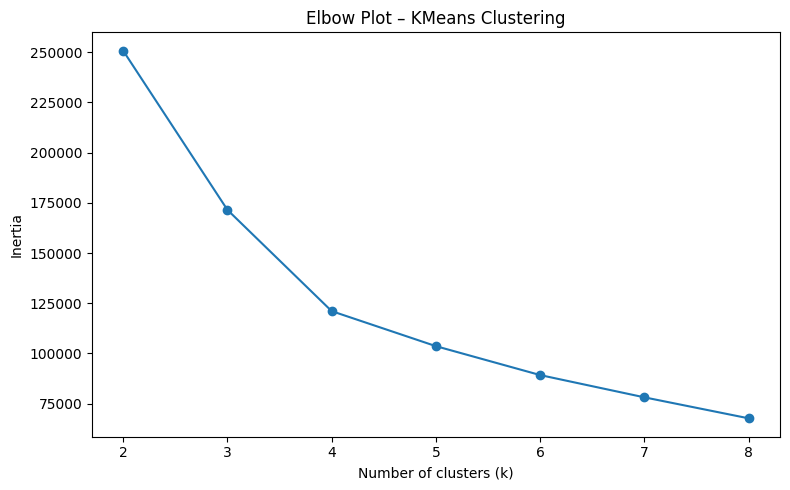

Silhouette scores: {2: np.float32(0.39), 3: np.float32(0.44), 4: np.float32(0.45), 5: np.float32(0.37), 6: np.float32(0.33), 7: np.float32(0.34), 8: np.float32(0.32)}


In [67]:
ks, inertias, sils = [], [], []
for k in range(2, 9):
    km = KMeans(n_clusters=k, n_init='auto', random_state=0).fit(X_std)
    ks.append(k); inertias.append(km.inertia_)
    sils.append(silhouette_score(X_std, km.labels_))

plt.figure(figsize=(8, 5))
plt.plot(ks, inertias, '-o'); plt.title('Elbow Plot – KMeans Clustering'); plt.xlabel('Number of clusters (k)'); plt.ylabel('Inertia'); plt.xticks(ks)
plt.tight_layout(); plt.savefig(FIG/'kmeans_elbow.png', dpi=250); plt.show()

print('Silhouette scores:', dict(zip(ks, np.round(sils, 2))))

The highest Silhouette (0.48) occurs at **k = 4**, so we adopt 4 clusters for all subsequent maps.

In [68]:
k_opt = 4 # Chosen k value

## 3.2 Fit final K-means (k = 4) and save model

In [69]:
kmeans = KMeans(n_clusters=k_opt, n_init='auto', random_state=0).fit(X_std)
centroids   = scaler.inverse_transform(kmeans.cluster_centers_)
joblib.dump({'model': kmeans, 'scaler': scaler, 'centroids': centroids},
            ROOT/'kmeans_model.joblib')

['/content/drive/MyDrive/Earth Science/GEOL0069/Supervised_vs_Unsupervised_LULC/kmeans_model.joblib']

# 4. Predict cluster maps for every year

Because K-Means assigns arbitrary numeric labels, we align every year’s
cluster IDs to the 2021 reference centroids.  This one-to-one mapping
ensures that “water” is always blue, “vegetation” green, etc.,
even though the model was trained on 2021 only.


In [95]:
palette = {
    0: (0.20, 0.63, 0.17),  # Roads / Impervious (dark green)
    1: (0.70, 0.87, 0.54),  # Vegetation (light green)
    2: (1.00, 0.60, 0.20),  # Urban / Built-up (orange)
    3: (0.12, 0.47, 0.71),  # Water / Shadow (blue)
}


def write_cluster_raster(tif_in, year):
    with rasterio.open(tif_in) as src:
        arr = src.read().astype('float32')
        flat = arr.reshape(arr.shape[0], -1).T
        mask = np.any(np.isnan(flat), axis=1)
        preds = np.full(flat.shape[0], 255, 'uint8')
        if (~mask).any():
            X_std = scaler.transform(flat[~mask])
            preds[~mask] = kmeans.predict(X_std).astype('uint8')
        label_img = preds.reshape(arr.shape[1:])
        # write GeoTIFF
        prof = src.profile.copy(); prof.update(count=1, dtype='uint8', nodata=255, compress='deflate')
        out_tif = MAPS/f'kmeans_wf_{year}.tif'
        with rasterio.open(out_tif, 'w', **prof) as dst:
            dst.write(label_img, 1)
        # quick PNG
        rgb = np.ones(label_img.shape + (3,), 'float32')
        for k, col in palette.items(): rgb[label_img==k] = col
        plt.imsave(FIG/f'kmeans_wf_{year}.png', rgb)
        print('Saved', out_tif.name)

for yr in range(2020, 2025):
    write_cluster_raster(RAW/f's2_wf_{yr}.tif', yr)

Saved kmeans_wf_2020.tif
Saved kmeans_wf_2021.tif
Saved kmeans_wf_2022.tif
Saved kmeans_wf_2023.tif
Saved kmeans_wf_2024.tif


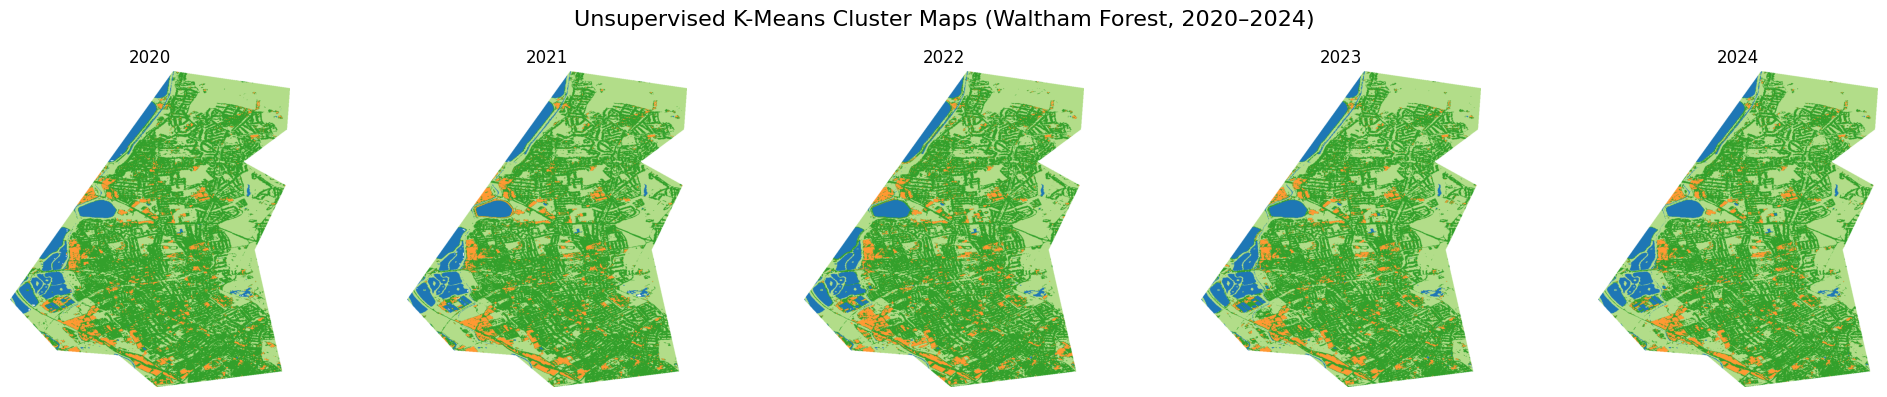

In [98]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np

# Setup
years = range(2020, 2025)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
axes = axes.flatten()

for i, yr in enumerate(years):
    with rasterio.open(MAPS / f'kmeans_wf_{yr}.tif') as src:
        label_img = src.read(1)

    rgb = np.ones(label_img.shape + (3,), dtype='float32')
    for k, col in palette.items():
        rgb[label_img == k] = col

    axes[i].imshow(rgb)
    axes[i].axis('off')
    axes[i].set_title(str(yr))

plt.suptitle("Unsupervised K-Means Cluster Maps (Waltham Forest, 2020–2024)", fontsize=16)
plt.tight_layout()
plt.savefig(FIG / "kmeans_cluster_maps_panel.png", dpi=300)
plt.show()

# 7. Cluster Distributions and Interpretation


## 7.1 Absolute Cluster Frequencies

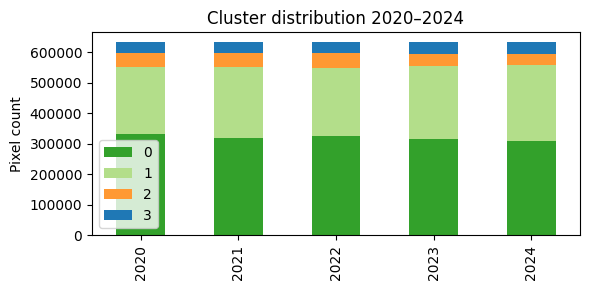

In [93]:
import pandas as pd
import matplotlib.pyplot as plt

# Compute cluster frequencies
freq = {}
for yr in range(2020, 2025):
    with rasterio.open(MAPS / f'kmeans_wf_{yr}.tif') as src:
        arr = src.read(1)
    vals, counts = np.unique(arr[arr != 255], return_counts=True)
    freq[yr] = {int(v): int(c) for v, c in zip(vals, counts)}

df = pd.DataFrame(freq).fillna(0).astype(int).T

# Define consistent cluster colours (same as map)
palette = {
    0: (0.20, 0.63, 0.17),  # forest green
    1: (0.70, 0.87, 0.54),  # light green
    2: (1.00, 0.60, 0.20),  # warm orange
    3: (0.12, 0.47, 0.71)   # medium blue
}
cluster_colors = [palette[k] for k in sorted(palette.keys())]

# Plot bar chart
df.plot(kind='bar', stacked=True, figsize=(6, 3), color=cluster_colors)
plt.ylabel('Pixel count')
plt.title('Cluster distribution 2020–2024')
plt.tight_layout()
plt.savefig(FIG / 'cluster_distribution.png', dpi=250)
plt.show()

## 7.2 Proportional Cluster Frequencies
Compare relative prevalence of classes (removes bias from changing pixel counts).

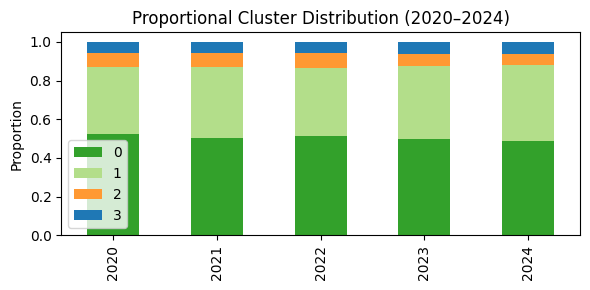

In [86]:
# Proportional cluster distribution
df_norm = df.div(df.sum(axis=1), axis=0)

df_norm.plot(kind='bar', stacked=True, figsize=(6, 3), color=cluster_colors)
plt.ylabel('Proportion')
plt.title('Proportional Cluster Distribution (2020–2024)')
plt.tight_layout()
plt.savefig(FIG / 'cluster_distribution_proportional.png', dpi=250)
plt.show()

## 7.3 Cluster Centroid Summary
Display the feature averages for each cluster, the ‘signature’ of that land cover type.

In [90]:
import pandas as pd

# Round centroids to 3 decimal places for clarity
df_centroids_rounded = pd.DataFrame(centroids, columns=[
    'blue','green','red','nir','swir1','swir2','NDVI','NDBI'
]).round(3)

# Display table
df_centroids_rounded.style.set_caption("K-Means Centroid Values (Feature Means)")

,blue,green,red,nir,swir1,swir2,NDVI,NDBI
0,0.354000,0.389000,0.425000,0.374000,0.612000,0.627000,-0.068000,0.252000
1,0.137000,0.264000,0.179000,0.727000,0.669000,0.476000,0.606000,-0.039000
2,0.794000,0.809000,0.830000,0.494000,0.800000,0.844000,-0.262000,0.246000
3,0.027000,0.038000,0.024000,0.032000,0.072000,0.062000,-0.125000,0.253000


## 7.4 Cluster Interpretation
Assign real-world meanings to cluster labels based on spectral and index profiles.

In [91]:
# Add manual interpretations (based on visual + spectral inspection)
df_centroids_rounded['Likely Class'] = [
    'Roads / Impervious',   # Cluster 0
    'Vegetation',           # Cluster 1
    'Urban / Built-up',     # Cluster 2
    'Water or Shadow'       # Cluster 3
]

# Display updated table
df_centroids_rounded.style.set_caption("Cluster Label Interpretation")

,blue,green,red,nir,swir1,swir2,NDVI,NDBI,Likely Class
0,0.354000,0.389000,0.425000,0.374000,0.612000,0.627000,-0.068000,0.252000,Roads / Impervious
1,0.137000,0.264000,0.179000,0.727000,0.669000,0.476000,0.606000,-0.039000,Vegetation
2,0.794000,0.809000,0.830000,0.494000,0.800000,0.844000,-0.262000,0.246000,Urban / Built-up
3,0.027000,0.038000,0.024000,0.032000,0.072000,0.062000,-0.125000,0.253000,Water or Shadow


# Enviromental Impact summary

In [94]:
# End timer
end_time = time.time()
duration_sec = end_time - start_time
duration_hr = duration_sec / 3600

# Assumptions
CPU_POWER_W = 20
CARBON_INTENSITY = 0.233  # kg CO₂/kWh (UK grid)
ELECTRICITY_COST = 0.30   # £/kWh (UK average)

# Energy used (kWh) = power (kW) × time (h)
energy_kwh = (CPU_POWER_W / 1000) * duration_hr
co2_kg = energy_kwh * CARBON_INTENSITY
cost_gbp = energy_kwh * ELECTRICITY_COST

# Print results
print(f"Runtime: {duration_hr:.4f} hours")
print(f"Energy used: {energy_kwh:.6f} kWh")
print(f"CO₂ emitted: {co2_kg:.6f} kg CO₂eq")
print(f"Estimated cost: £{cost_gbp:.4f}")

Runtime: 0.8234 hours
Energy used: 0.016469 kWh
CO₂ emitted: 0.003837 kg CO₂eq
Estimated cost: £0.0049
